<a href="https://colab.research.google.com/github/TSupattra/BADS7105_CRM_Analytics/blob/main/04_Campaign%20Response%20Model/Campaign_Response_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing libraries and datasets**

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_response = pd.read_csv('/content/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## Filter back three years

In [7]:
maxdate_3Y = df_transactions['trans_date'].max() + pd.offsets.DateOffset(years=-3)

In [8]:
maxdate_3Y

Timestamp('2012-03-16 00:00:00')

In [9]:
df_transactions = df_transactions[(df_transactions['trans_date'] > maxdate_3Y)]

In [10]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2012-03-17 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [11]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


In [12]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [13]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,12,800
1,CS1113,36.0,17,1246
2,CS1114,33.0,14,1006
3,CS1115,12.0,16,1216
4,CS1116,204.0,8,517


In [14]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [15]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,12,800,1011,66.666667
1,CS1113,36.0,17,1246,1046,73.294118
2,CS1114,33.0,14,1006,1005,71.857143
3,CS1115,12.0,16,1216,1046,76.000000
4,CS1116,204.0,8,517,872,64.625000


## **Calculating response rate**

In [16]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


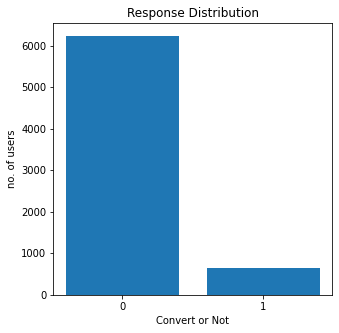

In [17]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [18]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,12,800
1,CS1113,0,36.0,17,1246
2,CS1114,1,33.0,14,1006
3,CS1115,1,12.0,16,1216
4,CS1116,1,204.0,8,517


In [19]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,12,800,1011,66.666667
1,CS1113,0,36.0,17,1246,1046,73.294118
2,CS1114,1,33.0,14,1006,1005,71.857143
3,CS1115,1,12.0,16,1216,1046,76.000000
4,CS1116,1,204.0,8,517,872,64.625000


## **Creating train and test dataset**

In [20]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [21]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

In [22]:
X_test_rfm

,recency,frequency,monetary_value
5546,28.0,13,527
3027,158.0,24,1658
6234,90.0,11,545
4308,19.0,13,790
3035,25.0,20,1391
...,...,...,...
2266,97.0,10,749
1303,42.0,19,1344
474,74.0,12,822
1789,191.0,16,1084


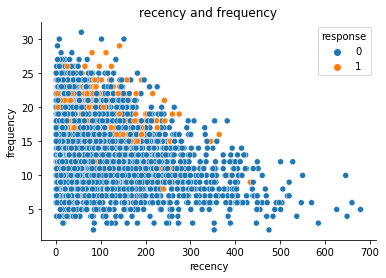

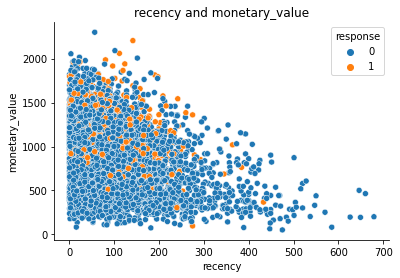

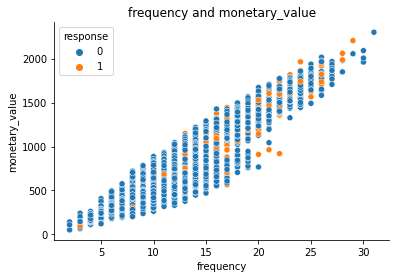

In [23]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

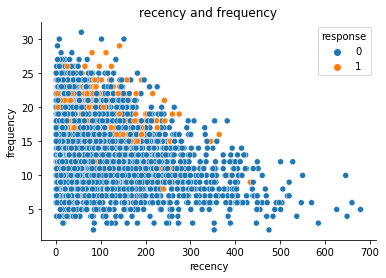

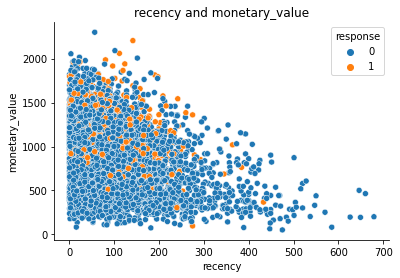

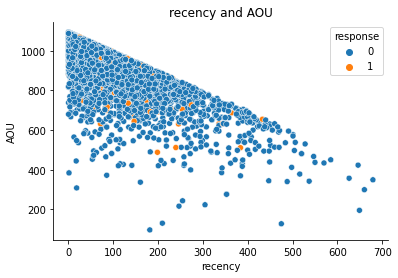

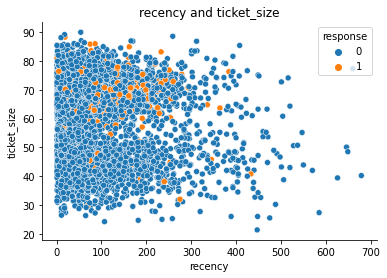

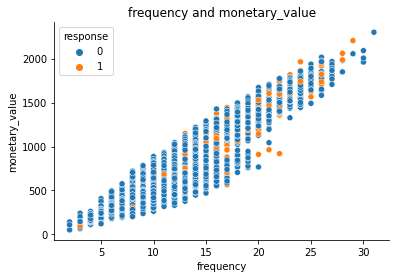

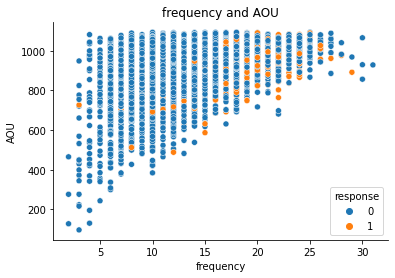

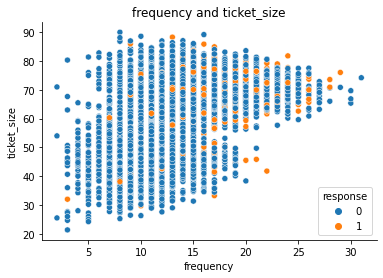

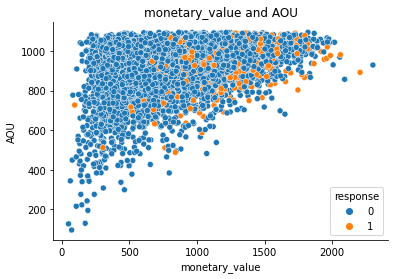

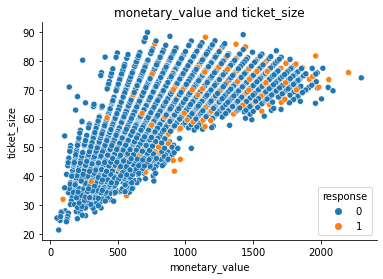

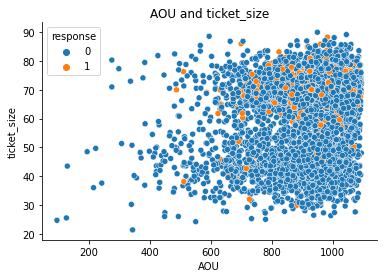

In [24]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [29]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [52]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      4389
           1       0.67      0.75      0.71      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.76      1848
           1       0.19      0.74      0.30       218

    accuracy                           0.64      2066
   macro avg       0.57      0.68      0.53      2066
weighted avg       0.87      0.64      0.71      2066



## ROC Curve for logistic regression model - SMOTE RFM

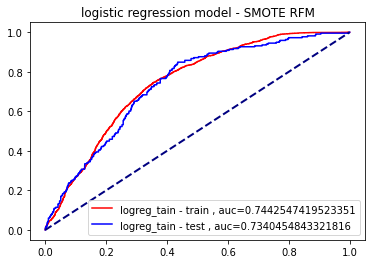

In [53]:
y_score_train = logreg_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_rfm, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='logreg_tain - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_rfm.predict_proba(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_rfm, y_score_test[:,1])
auc_test = roc_auc_score(y_test_rfm, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='logreg_tain - test , auc='+str(auc_test))

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')

plt.legend(loc=4)
plt.title("logistic regression model - SMOTE RFM")
plt.savefig('logistic_regression_model_SMOTE_RFM.png')

In [54]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      4389
           1       0.70      0.74      0.72      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.67      0.79      1848
           1       0.20      0.67      0.30       218

    accuracy                           0.67      2066
   macro avg       0.57      0.67      0.54      2066
weighted avg       0.87      0.67      0.74      2066



## ROC Curve for logistic regression model - SMOTE CLV


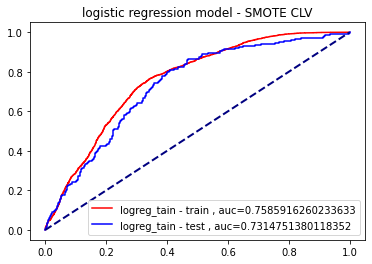

In [55]:
y_score_train = logreg_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='logreg_tain - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE_clv.predict_proba(X_test_clv)
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='logreg_tain - test , auc='+str(auc_test))

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("logistic regression model - SMOTE CLV")
plt.savefig('logistic_regression_model_SMOTE_CLV.png')
plt.show()

## **XGBoost**

### Optimization algorithm for - SMOTE RFM

In [ ]:
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [2,3,4,5,6],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100],
          'gamma': [ 0.0 ],
           'colsample_bytree': [0.3,0.6,1]}
xgbc = xgb.XGBClassifier()


rs_model=RandomizedSearchCV(xgbc,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)


rs_model.fit(X_SMOTE_rfm, y_SMOTE_rfm)
print("Best parameters:", rs_model.best_params_)




Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 1}


In [64]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.1,
 n_estimators=100,
 max_depth=2,
 gamma=0,
 colsample_bytree=1)

predicted_y = []
expected_y = []

# xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(np.array(X_test_rfm), y_test_rfm)])
xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm, y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.719966
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.735361
[2]	validation_0-auc:0.747492
[3]	validation_0-auc:0.742041
[4]	validation_0-auc:0.747275
[5]	validation_0-auc:0.750549
[6]	validation_0-auc:0.751678
[7]	validation_0-auc:0.751683
[8]	validation_0-auc:0.752038
[9]	validation_0-auc:0.75136
[10]	validation_0-auc:0.753607
[11]	validation_0-auc:0.752718
[12]	validation_0-auc:0.754027
[13]	validation_0-auc:0.755676
[14]	validation_0-auc:0.755653
[15]	validation_0-auc:0.755906
[16]	validation_0-auc:0.755277
[17]	validation_0-auc:0.754605
[18]	validation_0-auc:0.756548
[19]	validation_0-auc:0.755801
[20]	validation_0-auc:0.756389
[21]	validation_0-auc:0.755182
[22]	validation_0-auc:0.757282
[23]	validation_0-auc:0.757244
[24]	validation_0-auc:0.756763
[25]	validation_0-auc:0.756269
[26]	validation_0-auc:0.756263
[27]	validation_0-auc:0.755702
Stopping. Best iteration:
[22]	validation_0-auc:0.7572

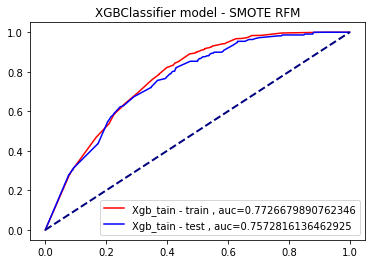

In [65]:
y_score_train = xgb_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_rfm, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_rfm, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='Xgb_tain - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_rfm.predict_proba(X_test_rfm)
fpr_test, tpr_test, _ = roc_curve(y_test_rfm, y_score_test[:,1])
auc_test = roc_auc_score(y_test_rfm, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='Xgb_tain - test , auc='+str(auc_test))

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')

plt.legend(loc=4)
plt.title("XGBClassifier model - SMOTE RFM")
plt.savefig('XGBClassifier_SMOTE_RFM.png')

### Optimization algorithm for - SMOTE CLV

In [66]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.1,
 n_estimators=100,
 max_depth=2,
 gamma=0,
 colsample_bytree=1)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.718455
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.734747
[2]	validation_0-auc:0.731337
[3]	validation_0-auc:0.736294
[4]	validation_0-auc:0.737043
[5]	validation_0-auc:0.735951
[6]	validation_0-auc:0.737082
[7]	validation_0-auc:0.747644
[8]	validation_0-auc:0.749093
[9]	validation_0-auc:0.750033
[10]	validation_0-auc:0.752414
[11]	validation_0-auc:0.745026
[12]	validation_0-auc:0.749337
[13]	validation_0-auc:0.749675
[14]	validation_0-auc:0.752852
[15]	validation_0-auc:0.754714
[16]	validation_0-auc:0.750413
[17]	validation_0-auc:0.751601
[18]	validation_0-auc:0.752266
[19]	validation_0-auc:0.752109
[20]	validation_0-auc:0.752292
Stopping. Best iteration:
[15]	validation_0-auc:0.754714

training set
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      4389
           1       0.67      0.84      0.74      4389

    accuracy                       

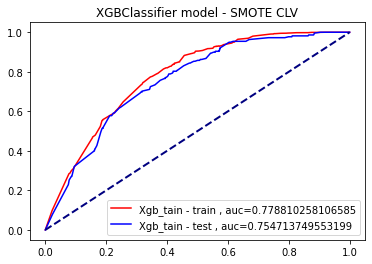

In [67]:
y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='Xgb_tain - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv)
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='Xgb_tain - test , auc='+str(auc_test))

plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title("XGBClassifier model - SMOTE CLV")
plt.savefig('XGBClassifier_SMOTE_CLV.png')
plt.show()